# Modeling with Large data

In [1]:
import os
import sys
import joblib

import numpy as np
import pandas as pd

# Import scikit-learn classes for building models
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix

In [2]:
!wget "https://raw.githubusercontent.com/LabReddy/Spam-or-Ham-Detection/main/spam.csv"

--2024-05-16 20:24:02--  https://raw.githubusercontent.com/LabReddy/Spam-or-Ham-Detection/main/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv.1’

spam.csv.1          100%[===================>] 491.86K  --.-KB/s    in 0.06s   

2024-05-16 20:24:02 (7.58 MB/s) - ‘spam.csv.1’ saved [503663/503663]



In [4]:
!wget "https://raw.githubusercontent.com/LabReddy/Spam-or-Ham-Detection/main/custom%20python%20functions/CustomPreprocessorSpacy.py"
!wget "https://raw.githubusercontent.com/LabReddy/Spam-or-Ham-Detection/main/custom%20python%20functions/FeaturizerSpacy.py"
!wget "https://raw.githubusercontent.com/LabReddy/Spam-or-Ham-Detection/main/custom%20python%20functions/plot_learning_curve.py"

--2024-05-16 20:24:49--  https://raw.githubusercontent.com/LabReddy/Spam-or-Ham-Detection/main/custom%20python%20functions/CustomPreprocessorSpacy.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7763 (7.6K) [text/plain]
Saving to: ‘CustomPreprocessorSpacy.py’

CustomPreprocessorS 100%[===================>]   7.58K  --.-KB/s    in 0s      

2024-05-16 20:24:49 (31.5 MB/s) - ‘CustomPreprocessorSpacy.py’ saved [7763/7763]

--2024-05-16 20:24:49--  https://raw.githubusercontent.com/LabReddy/Spam-or-Ham-Detection/main/custom%20python%20functions/FeaturizerSpacy.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.gith

In [5]:
import CustomPreprocessorSpacy as cp
from FeaturizerSpacy import ManualFeatures
from plot_learning_curve import plot_learning_curve

/Users/lalbahadurreddyindla/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
!pip install -U nltk -qq
!pip install -U spacy -qq
!python -m spacy download en_core_web_sm -qq

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
df_large = joblib.load('df_large.pkl')

In [12]:
class module:
  def __init__(self,X,y,preprocessor,pipeline,params,sparse=False,featurize=False):
    self.X=X
    self.y=y
    self.preprocessor=preprocessor
    self.pipeline=pipeline

    self.params=params

    # Boolean parameters
    self.sparse=sparse
    # if sparse is true, pipeline should include vectorizer
    self.featurize=featurize

    # Featuerizer
    self.featurizer=ManualFeatures(spacy_model='en_core_web_sm',
                                   batch_size = 1000)

  def __call__(self,**kwargs):
    '''
    run the whole module

    preprocessing
    spliting
    feature engineering
    randomsearch
    train report
    test report
    '''

    #preprocessing
    X_train, X_test, y_train, y_test=self._preprocessing()

    #feature engineering
    _,__=self._feature_engineering(X_train, X_test, y_train, y_test,**kwargs)

    #random CV fitting
    self._fit(self.X_train,self.y_train)

    #report train result
    self._train_report()

    #report test result
    self._predict(self.X_test,self.y_test)

  def _preprocessing(self):
    '''
    This process use preprocessor and split data

    split ratio is 0.8:0.2

    '''

    from sklearn.model_selection import train_test_split
    self.X_preprocessing=self.preprocessor.fit_transform(self.X)

    #return X_train, X_test, y_train, y_test
    return train_test_split(self.X_preprocessing,
                            self.y,
                            test_size=0.2,
                            random_state=42)

  def _feature_engineering(self,X_train, X_test, y_train, y_test,**kwargs):

    '''
    kwargs finds specific features the model will use

    '''
    R=['count_words','count_characters','count_characters_no_space',
     'avg_word_length','count_numbers', 'count_sentences',
     'noun_count', 'aux_count', 'verb_count', 'adj_count', 'ner']

    if 'featurizer_items' in kwargs.keys():
      L=kwargs['featurizer_items']
      N = [i for i in range(len(L)) if L[i] in R]

    #case 1
    if (self.featurize==True) and (self.sparse==False):
      X_train_feature,_=self.featurizer.fit_transform(X_train)
      X_test_feature,_=self.featurizer.fit_transform(X_test)
      if 'featurizer_items' in kwargs.keys():
        X_train_feature=X_train_feature[:, N]
        X_test_feature=X_test_feature[:, N]

      self.X_train=X_train_feature
      self.y_train=y_train
      self.X_test=X_test_feature
      self.y_test=y_test
    #case 2
    elif (self.featurize==False) and (self.sparse==True):
      self.X_train=X_train
      self.y_train=y_train
      self.X_test=X_test
      self.y_test=y_test
    #case 3
    elif (self.featurize==True) and (self.sparse==True):
      X_train_feature,_=self.featurizer.fit_transform(X_train)
      X_test_feature,_=self.featurizer.fit_transform(X_test)
      if 'featurizer_items' in kwargs.keys():
        X_train_feature=X_train_feature[:, N]
        X_test_feature=X_test_feature[:, N]
        feature_names=[R[i] for i in N]
      else:
        feature_names=R
      self.X_train= pd.concat((pd.DataFrame(X_train, columns=['cleaned_text']),
                               pd.DataFrame(X_train_feature, columns=feature_names)), axis=1)
      self.y_train=y_train
      self.X_test= pd.concat((pd.DataFrame(X_test, columns=['cleaned_text']),
                               pd.DataFrame(X_test_feature, columns=feature_names)), axis=1)
      self.y_test=y_test
    else :

      raise Exception('check sparseembedding or featurizer')

    return self.X_train,self.X_test


  def _fit(self,X_train,y_train):
    '''
    we use fbeta score as a scoring function.
    fbeta score can give a weight on precision, and this can leverage imbalanced data
    '''
    from sklearn.metrics import fbeta_score, make_scorer
    fbeta_scorer = make_scorer(fbeta_score,
                               zero_division=0,
                               beta=0.5)

    self.model=HalvingRandomSearchCV(self.pipeline,
                                              self.params,
                                              random_state=42,
                                              scoring=fbeta_scorer,
                                              cv=10)
    self.model.fit(X_train, y_train)

  def _train_report(self):
    print(f'Best cross-validation score: {self.model.best_score_:.2f}')
    print("\nBest parameters: ", self.model.best_params_)
    print("\nBest estimator: ", self.model.best_estimator_)

  def _predict(self,X_test,y_test):
    y_pred = self.model.best_estimator_.predict(X_test)
    print(classification_report(y_test, y_pred))
    from sklearn.metrics import fbeta_score
    print(fbeta_score(y_test, y_pred, average=None, beta=0.5))


  def plot(self):
    plot_learning_curve(self.model.best_estimator_,
                        'Learning Curves',
                        self.X_train,
                        self.y_train,
                        n_jobs=-1)



In [18]:
preprocessor_1=cp.SpacyPreprocessor(model='en_core_web_sm',
                                    batch_size = 500,
                                    lower=False,  # spam has CAPITAL cases
                                    remove_email=False, # spam has email address
                                    remove_url=False,)  # spam has url dataX=df_large['message'].tolist()
X = df_large['message'].tolist()
y=df_large['label'].tolist()
classifier_3 = None
param_classifier_3 =None

In [19]:
m3=module(X,y,preprocessor_1,classifier_3,param_classifier_3,sparse=True,featurize=True)

In [20]:
X_train, X_test, y_train, y_test=m3._preprocessing()

feat_dict={
  'featurizer_items':[
    'count_words', # ham has not much words
    'count_characters',  # ham has not much words
    'count_characters_no_space',
    'avg_word_length',  # ham has not much words
    'count_numbers', # ham has not much words
    'count_sentences', # ham has not much words
    'noun_count',
    'aux_count',
    'verb_count',
    #'adj_count',   # both spam and ham has not much words
    'ner'
  ]
}
X_train,X_test=m3._feature_engineering(X_train, X_test, y_train, y_test,**feat_dict)

/Users/lalbahadurreddyindla/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [21]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)


In [23]:
sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")), ])
sparse_features.fit_transform(X_train.iloc[:, 1:])
vectorizer.fit_transform(X_train.iloc[:, 0])
combined_features = ColumnTransformer(
    transformers=[
        ('tfidf', vectorizer, 'cleaned_text'),
    ], remainder=sparse_features
)
classifier_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', RandomForestClassifier()),
                         ])
param_classifier_3 = {
    'combined_features__tfidf__tfidf__max_df':[0.5, 0.6, 0.7], # ignore terms which appears more than 0.X
    'combined_features__tfidf__tfidf__ngram_range':[(1, 1), (1, 2), (1,3),],
    #'combined_features__tfidf__tfidf__min_df':[0.1,0.5,1],
    'combined_features__tfidf__tfidf__max_features': [500, 1000, 5000],
    'classifier__max_depth':[5,15,50,None],
    'classifier__n_estimators':[10,100,200],
    'classifier__max_features':[1,5,10,None],
    'classifier__min_samples_leaf':[1,5,10]
}

In [24]:
m3=module(X,y,preprocessor_1,classifier_3,param_classifier_3,sparse=True,featurize=True)

In [25]:
feat_dict={
  'featurizer_items':[
    'count_words',
    'count_characters',
    'count_characters_no_space',
    'avg_word_length',
    'count_numbers',
    'count_sentences',
    'noun_count',
    'aux_count',
    'verb_count',
    #'adj_count',
    'ner'
  ]
}
m3(**feat_dict)

/Users/lalbahadurreddyindla/anaconda3/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Best cross-validation score: 0.88

Best parameters:  {'combined_features__tfidf__tfidf__ngram_range': (1, 3), 'combined_features__tfidf__tfidf__max_features': 500, 'combined_features__tfidf__tfidf__max_df': 0.7, 'classifier__n_estimators': 100, 'classifier__min_samples_leaf': 1, 'classifier__max_features': None, 'classifier__max_depth': 5}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_df=0.7,
                                                                                   max_features=500,
                                                                                   ngram_range=(1,
              

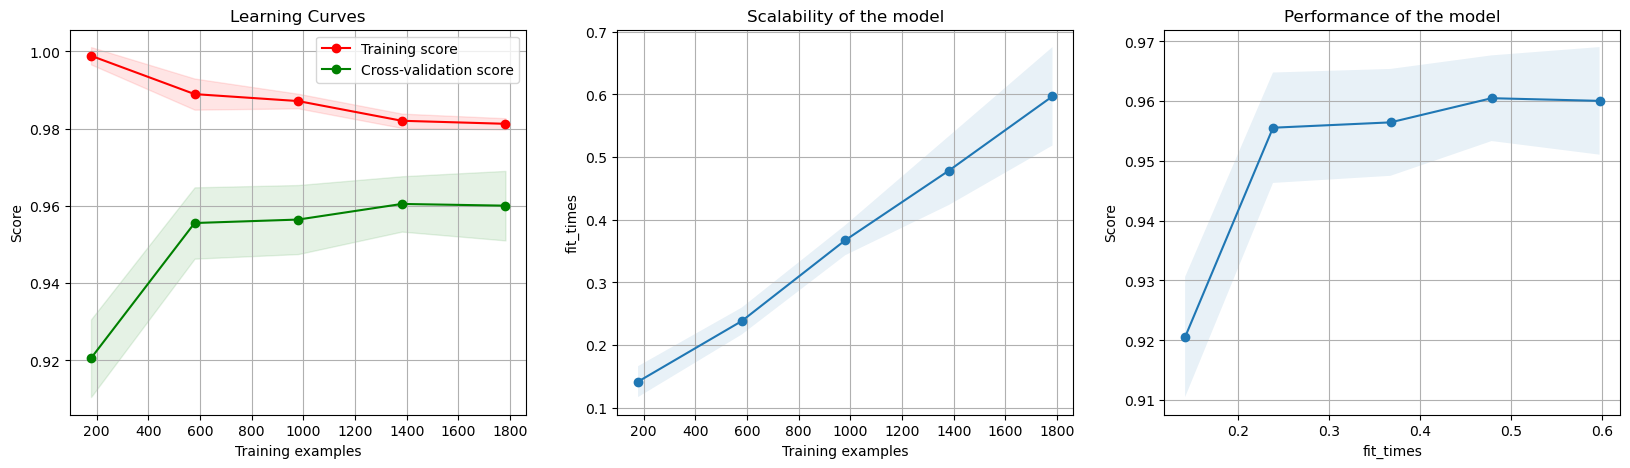

In [26]:
m3.plot()